<a href="https://colab.research.google.com/github/contribcode/social_networks_theory_and_practice/blob/master/Social_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from itertools import combinations
from collections import Counter

import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.cm as cm

from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances

import networkx as nx
import seaborn as sns
sns.set()

import community as community_louvain

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
clusters = pd.read_csv('/content/drive/My Drive/Social Networks/'
                       'email-Eu-core-department-labels.txt',
                       names=['member', 'department'],
                       delim_whitespace=True)

# Graph

In [5]:
G=nx.read_edgelist('/content/drive/My Drive/Social Networks/email-Eu-core.txt',
                   create_using=nx.Graph(),
                   nodetype=int)

G.remove_edges_from(nx.selfloop_edges(G))
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 986
Number of edges: 16064
Average degree:  32.5842


remove nodes that have been removed from graph

In [0]:
clusters = \
  clusters[~clusters.member.isin(isolated_nodes)]

In [7]:
clusters.shape

(986, 2)

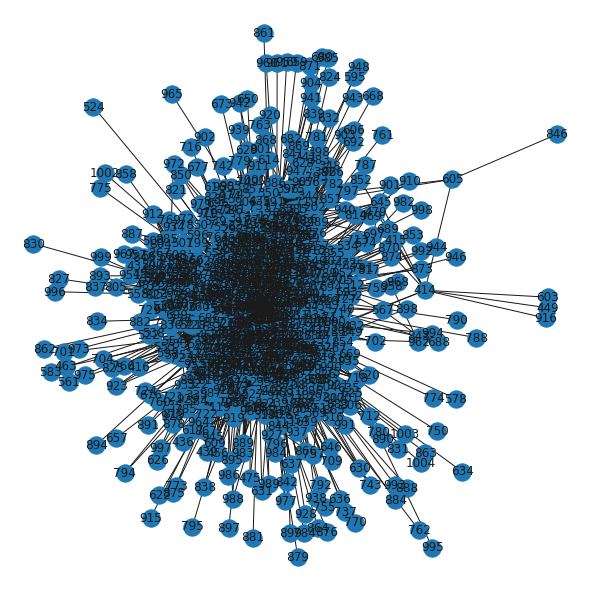

In [8]:
# fixing the size of the figure
plt.figure(figsize =(8,8))
nx.draw(G, with_labels=True)
W = nx.adjacency_matrix(G,nodelist=sorted(G.nodes()))

## pre-processing

**Laplace matrix**

In [9]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[42  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 93 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]
laplacian matrix:
[[42 -1  0 ...  0  0  0]
 [-1 50  0 ...  0  0  0]
 [ 0  0 93 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]


# Clustering

## eigenvectors - eigenvalues - number of clusters

In [0]:
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 10):
    """
    :param A: Adjacency matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given adjacency matrix,
    following the steps recommended in the paper:
    1. Find the eigenvalues and their associated eigen vectors
    2. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    """
    #n_components = A.shape[0] delete?
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    
    if plot:
        plt.title('Largest eigenvalues of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigenvalues
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Optimal number of clusters[ 72 513 609 662 201 542 204 546 746 432]


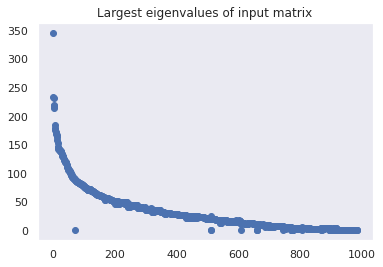

In [11]:
nb_clusters, eigenvalues, eigenvectors = eigenDecomposition(L)

print('Optimal number of clusters{}'.format(nb_clusters))

In [0]:
eigenvalues=eigenvalues.real
eigenvectors=eigenvectors.real
#print(eigenvalues)
#print(eigenvectors)

In [0]:
#print('eigenvectors:')
eigenvectors = eigenvectors[:,np.argsort(eigenvalues)]
#print(eigenvectors)
#print('-------')
eigenvalues = eigenvalues[np.argsort(eigenvalues)]
#print('eigenvalues:')
#print(eigenvalues)

In [0]:
kmeans = KMeans(n_clusters=72,random_state=128)
kmeans.fit(eigenvectors[:,1:15])
colors = kmeans.labels_

In [0]:
clusters['spectral_department'] = colors

In [0]:
# print(Counter(colors).values())
# print("Clusters:", colors)
# print(len(Counter(colors).values()))
# i=0
# for k,v in Counter(colors).items():
#     if v == 1:
#         i+=1
# print(i)

[57, 1, 2, 3, 1, 1, 1, 5, 5, 1, 2, 6, 6, 7, 1, 16, 77, 1, 2, 6, 2, 18, 2, 2, 4, 1, 4, 2, 5, 1, 3, 1, 3, 1, 8, 1, 1, 1, 5, 1, 2, 1, 15, 1, 2, 451, 2, 7, 2, 8, 17, 2, 3, 2, 1, 1, 3, 5, 49, 1, 2, 1, 10, 3, 45, 2, 35, 7, 29, 7, 1, 2]
72
3


In [16]:
clusters.head()

,member,department,spectral_department
0,0,1,0
1,1,1,0
2,2,21,0
3,3,21,0
4,4,21,0


# statistics

**create a dictionary of lists that represent clusters**

**each cluster is a list of vertices**

Ground truth Clusters

In [0]:
def add_cluster_member(member, department):
  if department in ground_truth_clusters:
    ground_truth_clusters[department].append(member)
  else:
    ground_truth_clusters[department] = [member]

In [0]:
ground_truth_clusters = dict()

s = clusters.apply(lambda row: add_cluster_member(row.member, 
                                                       row.department), axis=1)

number of nodes in a cluster

In [38]:
len(ground_truth_clusters)

42

In [0]:
len_list = list()

for k, v in ground_truth_clusters.items():

  cluster_len = len(v)
  len_list.append(cluster_len)

In [0]:
gt_df = pd.DataFrame(data=len_list, columns=['cluster_length'])
gt_df

In [45]:
gt_df.cluster_length.value_counts()

13     3
1      2
49     2
3      2
4      2
6      2
29     2
8      2
9      2
10     2
12     2
18     1
2      1
5      1
15     1
27     1
62     1
56     1
22     1
24     1
25     1
26     1
91     1
28     1
31     1
34     1
39     1
107    1
54     1
19     1
Name: cluster_length, dtype: int64

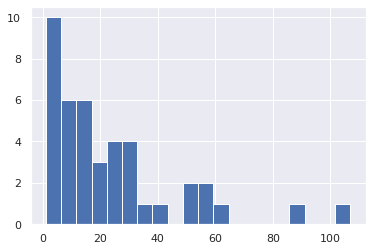

In [44]:
gt_df.cluster_length.hist(bins=20)

Clusters of Spectral clustering Algorithm

In [0]:
spectral_clusters = dict()

for idx, n in enumerate(colors):
  if n in spectral_clusters:
    spectral_clusters[n].append(idx)
  else:
    spectral_clusters[n] = [idx]

In [0]:
def ground_truth_cl(department):
  return ground_truth_clusters[department]

# metrics

In [0]:
def common_members(department, spectral_department):
  spectral_cl = set(spectral_clusters[spectral_department])
  ground_truth_cl = set(ground_truth_clusters[department])
  cm = spectral_cl.intersection(ground_truth_cl)
  return cm

In [0]:
clusters['ground_truth_cl'] = clusters.department.apply(ground_truth_cl)

In [0]:
clusters['len_gtc'] = clusters.ground_truth_cl.apply(len)

In [0]:
clusters['common_members'] = clusters.apply(
    lambda row: common_members(row.department, row.spectral_department), axis=1)

In [0]:
clusters['len_cm'] = clusters.common_members.apply(len)

In [0]:
clusters.head()

,member,department,spectral_department,ground_truth_cl,len_gtc,common_members,len_cm,correct_cl
0,0,1,65,"[0, 1, 17, 18, 73, 74, 85, 120, 177, 215, 218,...",62,"{0, 1, 228, 225, 74, 221, 17, 308, 309, 310, 2...",17,0
1,1,1,65,"[0, 1, 17, 18, 73, 74, 85, 120, 177, 215, 218,...",62,"{0, 1, 228, 225, 74, 221, 17, 308, 309, 310, 2...",17,0
2,2,21,64,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,"{2, 3, 520, 137, 138, 532, 408, 281, 412, 286,...",22,0
3,3,21,64,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,"{2, 3, 520, 137, 138, 532, 408, 281, 412, 286,...",22,0
4,4,21,22,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,{4},1,0


In [0]:
clusters['correct_cl'] = clusters.apply(lambda row: 1 if float(row.len_cm)/float(row.len_gtc) >= 0.5 else 0, axis=1)

In [0]:
clusters.correct_cl.sum()

50

In [0]:
50.0/968.0

0.05165289256198347

**1 metric**

**fraction of correctly classified vertices**

In [0]:
def frac_correctly(department, spectral_department):
  ground_thruth_cl = set(ground_truth_clusters[department])
  spectral_cl = set(spectral_clusters[spectral_department])

  common_members_len = len(ground_thruth_cl.intersection(spectral_cl))
  ground_truth_len = len(ground_thruth_cl)

  if common_members_len >= ground_truth_len / 2:
    return 1
  else:
    return 0

In [0]:
clusters['metric_1'] = clusters.apply(
    lambda row: frac_correctly(row.department, row.spectral_department), axis=1)

In [0]:
clusters.metric_1.sum() /clusters.shape[0]

0

**metric 2**

**Rand Index**

In [0]:
a00 = 0
a01 = 0
a10 = 0
a11 = 0

members = set(clusters.member.to_list())

combs = combinations(members, 2)

for cbs in combs:

  member_1 = cbs[0]
  member_2 = cbs[1]

  row_1 = clusters[clusters.member==member_1]
  row_2 = clusters[clusters.member==member_2]

  # ground truth clusters
  gt_member_1 = row_1['department'].iloc[0]
  gt_member_2 = row_2['department'].iloc[0]

  # spectral clusters
  sp_member_1 = row_1['spectral_department'].iloc[0]
  sp_member_2 = row_2['spectral_department'].iloc[0]

  if gt_member_1 == gt_member_2:
    if sp_member_1 == sp_member_2:
      a11 += 1
    else:
      a10 += 1
  else:
    if sp_member_1 == sp_member_2:
      a01 += 1
    else:
      a00 += 1

In [0]:
numerator = a00+a11
denominator = a00+a01+a10+a11
metric_2 = float(numerator)/float(denominator)
metric_2

0.914772294354465

In [0]:
a00

440138

In [0]:
a01

22975

In [0]:
a10

18412

In [0]:
a11

4080

# Louvain Algorithm

7


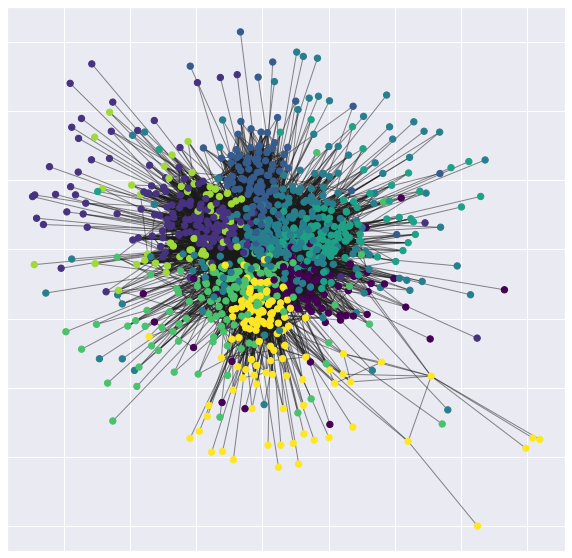

In [25]:
# fixing the size of the figure 
plt.figure(figsize =(10, 10))
# compute the best partition
partition = community_louvain.best_partition(G)
print(max(partition.values()))

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [0]:
louvain_clusters = dict()

for k, v in partition.items():
  if v in louvain_clusters:
    louvain_clusters[v].append(k)
  else:
    louvain_clusters[v] = [k]

In [0]:
clusters['louvain_department'] = list(partition.values())

**1 metric**

**fraction of correctly classified vertices**

In [0]:
def common_members_louvain(department, louvain_department):
  louvain_cl = set(louvain_clusters[louvain_department])
  ground_truth_cl = set(ground_truth_clusters[department])
  cm = louvain_cl.intersection(ground_truth_cl)
  return cm

In [0]:
clusters['common_members_louvain'] = clusters.apply(
    lambda row: common_members_louvain(row.department, row.louvain_department), axis=1)

In [0]:
clusters['len_cm_louvain'] = clusters.common_members_louvain.apply(len)

In [0]:
clusters['correct_cl_louvain'] = \
  clusters.apply(lambda row: 1 if float(row.len_cm_louvain)/float(row.len_gtc) >= 0.5 else 0, axis=1)

In [62]:
clusters.correct_cl_louvain.sum()

841

In [64]:
841/986

0.8529411764705882

In [60]:
clusters.head()

,member,department,spectral_department,ground_truth_cl,len_gtc,louvain_department,common_members_louvain,len_cm_louvain,correct_cl_louvain
0,0,1,0,"[0, 1, 17, 18, 73, 74, 85, 120, 177, 215, 218,...",62,0,"{0, 1, 775, 905, 650, 17, 18, 297, 177, 307, 3...",44,1
1,1,1,0,"[0, 1, 17, 18, 73, 74, 85, 120, 177, 215, 218,...",62,0,"{0, 1, 775, 905, 650, 17, 18, 297, 177, 307, 3...",44,1
2,2,21,0,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,1,"{2, 3, 4, 899, 774, 901, 520, 137, 138, 532, 4...",53,1
3,3,21,0,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,1,"{2, 3, 4, 899, 774, 901, 520, 137, 138, 532, 4...",53,1
4,4,21,0,"[2, 3, 4, 56, 57, 58, 59, 63, 137, 138, 192, 1...",56,1,"{2, 3, 4, 899, 774, 901, 520, 137, 138, 532, 4...",53,1


**metric 2**

**Rand Index**

In [0]:
a00 = 0
a01 = 0
a10 = 0
a11 = 0

members = set(clusters.member.to_list())

combs = combinations(members, 2)

for cbs in combs:

  member_1 = cbs[0]
  member_2 = cbs[1]

  row_1 = clusters[clusters.member==member_1]
  row_2 = clusters[clusters.member==member_2]

  # ground truth clusters
  gt_member_1 = row_1['department'].iloc[0]
  gt_member_2 = row_2['department'].iloc[0]

  # spectral clusters
  lv_member_1 = row_1['louvain_department'].iloc[0]
  lv_member_2 = row_2['louvain_department'].iloc[0]

  if gt_member_1 == gt_member_2:
    if lv_member_1 == lv_member_2:
      a11 += 1
    else:
      a10 += 1
  else:
    if lv_member_1 == lv_member_2:
      a01 += 1
    else:
      a00 += 1

In [66]:
numerator = a00+a11
denominator = a00+a01+a10+a11
metric_2 = float(numerator)/float(denominator)
metric_2

0.8836399954695688

In [67]:
a00

410601

In [68]:
a01

52512

In [69]:
a10

3993

In [70]:
a11

18499